In [32]:
!poetry add scikit-learn

The following packages are already present in the pyproject.toml and will be skipped:

  - scikit-learn

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use('fast')

In [34]:
data_path = '/home/hasierza/datos_originales/'
df = pd.read_csv(data_path + 'feature_frame.csv')

In [35]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [36]:
df['outcome'].value_counts() #para ver como funcionaba el outcome y para ver q esta desbalanceado

outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [38]:
info_cols = ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date'] #columnas de informacion
label_col = 'outcome'
features_cols = [col for col in df.columns if col not in info_cols + [label_col]] #columnas de features, todas menos las de info y label

cateforical_cols = ['product_type', 'vendor'] #columnas categoricas
binary_cols = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular'] #columnas binarias
numerical_cols = [col for col in features_cols if col not in cateforical_cols + binary_cols] #columnas numericas, todas menos las de info, label, categoricas y binarias

In [39]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame: # solo consideramos  pedidos q al menos min_products , pedidos que son rentables
    """" we will only consider users that have ordered at least min_products times, orders that are profitable """
    order_size = df.groupby('order_id').outcome.sum() #cuantos productos se han comprado
    order_size_min_size = order_size[order_size >= min_products].index #nos quedamos con los orders que han comprado al menos min_products 
    return df.loc[lambda x: x.order_id.isin(order_size_min_size)] #devolvemos el dataframe con los orders que han comprado al menos min_products , hacemos el filtro

df_selected = (
    df
    .pipe(push_relevant_dataframe)#aplicamos la funcion push_relevant_dataframe y nos devuelve el nuevo dataframe
    .assign(created_at = lambda x: pd.to_datetime(x.created_at)) #convertimos la columna created_at a datetime
    .assign(order_date = lambda x: pd.to_datetime(x.order_date).dt.date) # convertimos la columna order_date a datetime y nos quedamos solo con la fecha sin la hora
)

In [40]:
df.order_id.nunique() > df_selected.order_id.nunique()#comprobamos que se ha filtrado correctamente

True

In [41]:
total_userss=len(df_selected['user_id'])
train_size_cutoff = int(total_userss * 0.7)
validation_size = int(total_userss * 0.2)
validation_size_cuytoff = train_size_cutoff + validation_size
test_size = total_userss - train_size_cutoff - validation_size
print(f'Train size: {train_size_cutoff}, Validation size: {validation_size}, Test size: {test_size}, Total size: {total_userss}')


Train size: 1514767, Validation size: 432790, Test size: 216396, Total size: 2163953


In [42]:
datos_ordenados = df_selected.sort_values(by='user_id', ascending=True)



In [43]:
train_df = datos_ordenados.iloc[:train_size_cutoff]
val_df = datos_ordenados.iloc[train_size_cutoff:validation_size_cuytoff]
test_df = datos_ordenados.iloc[validation_size_cuytoff:]


Este split esta mal hecho no? 
Yo queria hacer el split por usuario es decir q un usuario solo pudiera estar en train, val o test, pero solo en uno.
Con esto q he hecho no consigo eso no?
Porque lo q he hecho es ordenar el dataset por user_id y luego cojer los de 0 a %70 para el train, del 70 al 90 al validation y el resto para test. Pero puede darse q un usuario este en train y validation, no? 

******************

aqui abajo seria haciendo el split por tiempo y usuarios.

In [44]:
dayly_orders = df_selected.groupby('order_date').user_id.nunique()

In [45]:
cumsum_daily_orders = dayly_orders.cumsum() / dayly_orders.sum() 

train_val_cutoff = cumsum_daily_orders [cumsum_daily_orders <= 0.7].idxmax() #nos quedamos con el 70% de los datos para train 
val_test_cutoff = cumsum_daily_orders [cumsum_daily_orders <= 0.9].idxmax() # nos quedamos con el 20% de los datos para val y el resto para test

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)

print("Val until:", val_test_cutoff)

print("Test until:", cumsum_daily_orders.index.max()) #hay q tener cuidado con los splits, imagina que el test solo tiene dos dias, no es representativo pero en este caso tien mas de de diez dias.

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


In [46]:
train_time_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_time_df = df_selected[(df_selected.order_date > train_val_cutoff) & (df_selected.order_date <= val_test_cutoff)]
test_time_df = df_selected[df_selected.order_date > val_test_cutoff]

## Baseline

In [47]:
def plot_metrics (
        model_name:str, y_pred:pd.Series, y_test:pd.Series, target_precision:float=0.85,
        figure: Tuple [matplotlib. figure. Figure, np.array]=None
    ):
    precision_, recall_, _ = precision_recall_curve(
        y_test, y_pred

    )
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    else:
        fig, ax = figure

    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall Curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"{model_name}; AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC Curve")
    ax[1].legend()


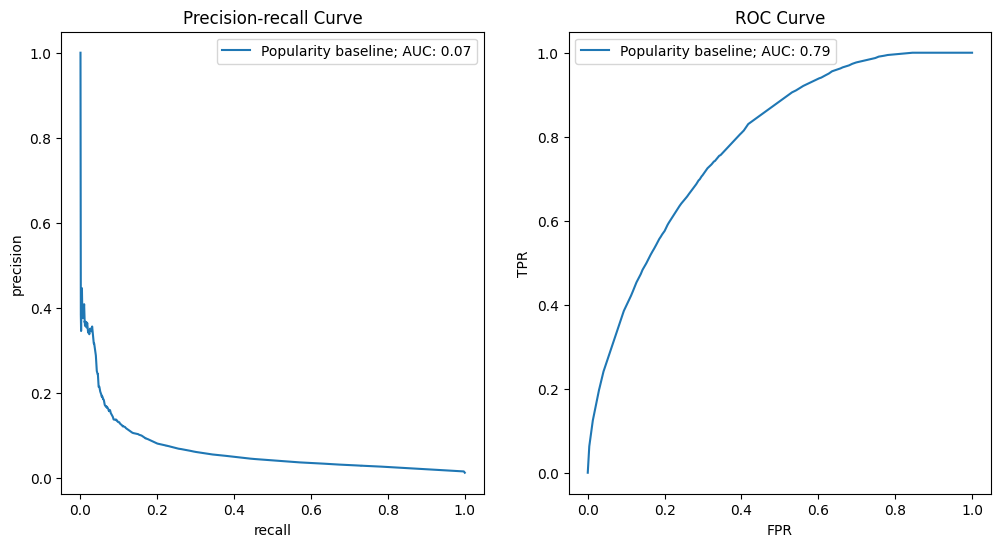

In [48]:
plot_metrics("Popularity baseline", y_pred= val_df["global_popularity"], y_test=val_df[label_col])


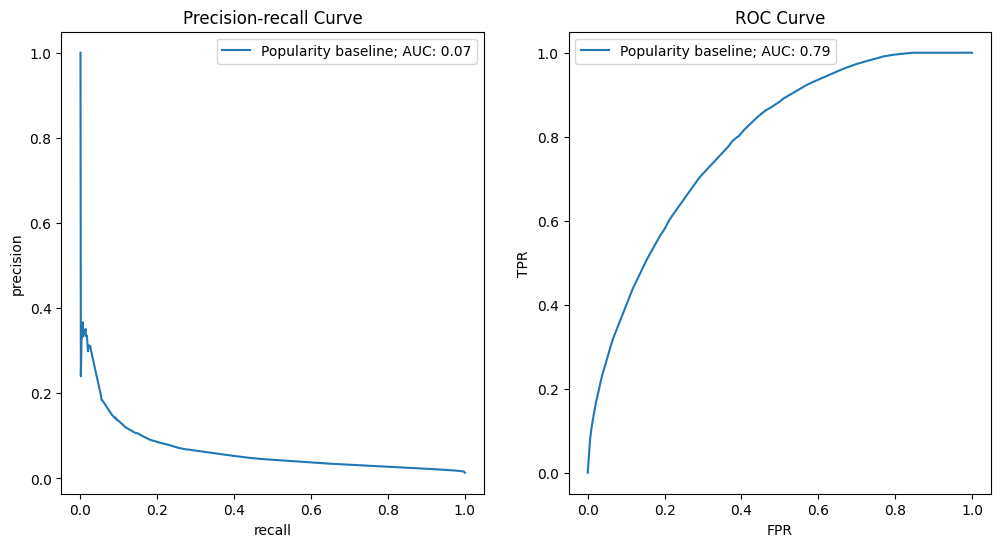

In [49]:
plot_metrics("Popularity baseline", y_pred= val_time_df["global_popularity"], y_test=val_time_df[label_col])


He ido haciendo diferentes pruebas para ver como cambiaban las curvas, en un principio compare usando el split por usuario contra temporalidad y usuarios a la vez. La curva roc me daba parecida y pensaba q era porque al ser un problema desvalanceado el split no afectaria tanto. La precision recal curve si q me daba diferente.

Pero he vuelto a calcular las curbas con esos dos splits y me da bastante parecido.

Se ha calculado el baseline usando la popularidad, ahora se va a intentar mejorar esas curvas entrenando modelos.

## Model training

In [51]:
def feature_label_split(df: pd.DataFrame, label_col: str) ->Tuple[pd.DataFrame, pd.Series]: #separamos las features del label en x e y.
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)
X_test, y_test = feature_label_split(test_df, label_col)


In [52]:
train_cols = numerical_cols + binary_cols#columnas que vamos a usar para entrenar el modelo, quitamos las categoricas porque quiero empezar con un modelo simple

### Ridge regresion

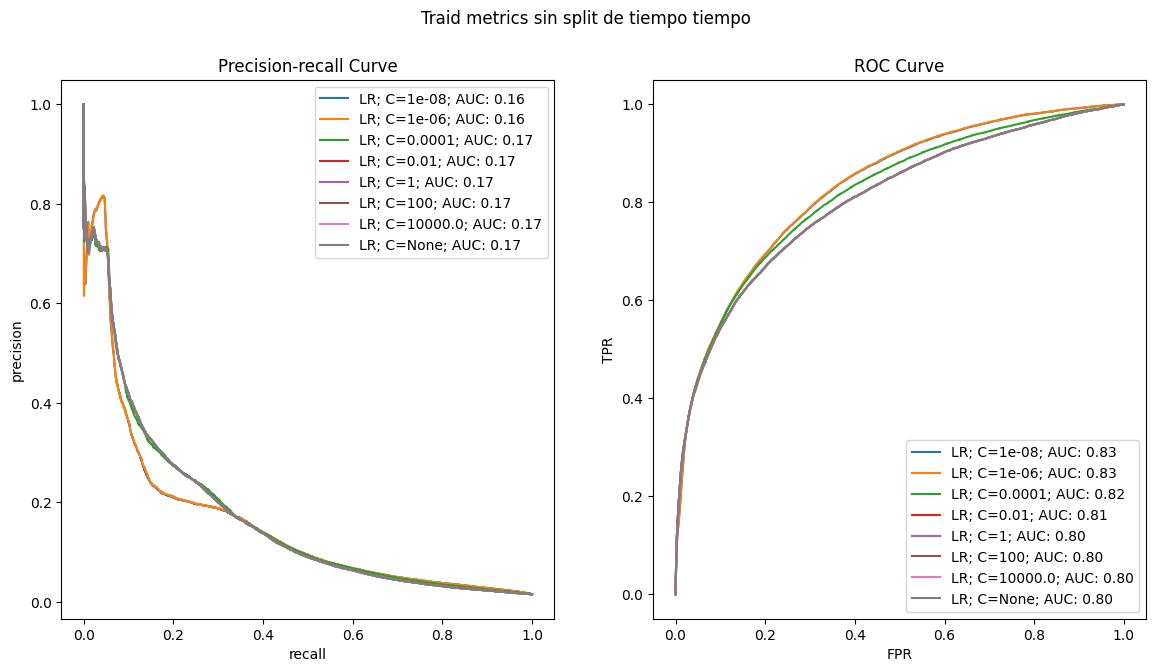

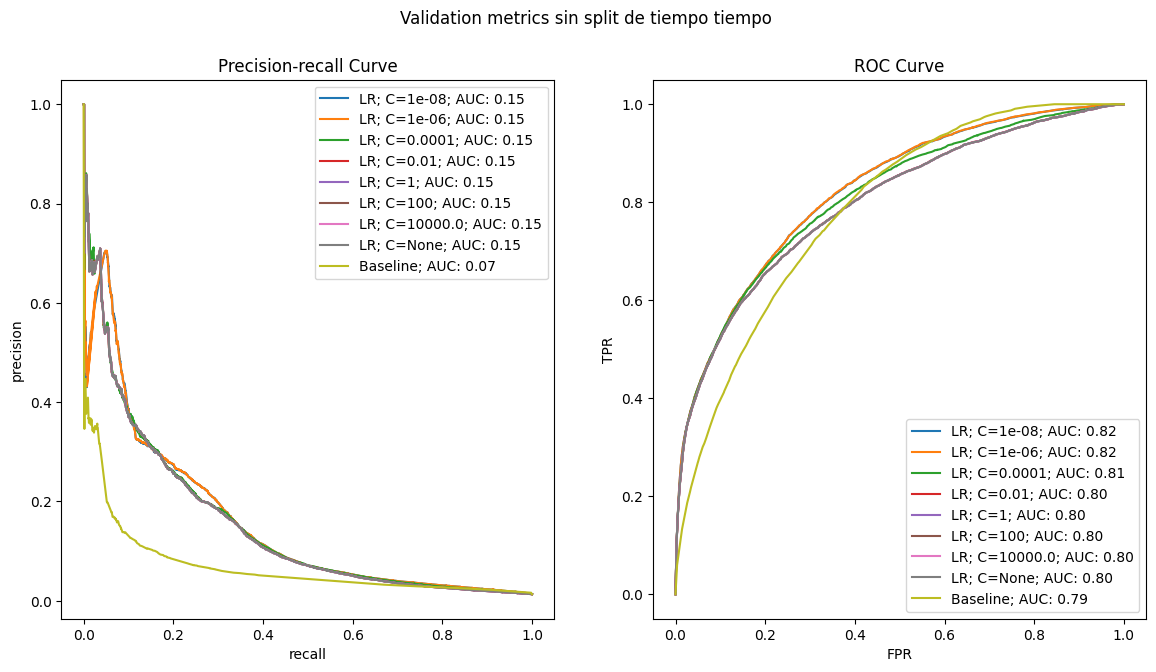

In [53]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

figl, ax1 = plt.subplots(1, 2, figsize=(14, 7))
figl.suptitle("Traid metrics sin split de tiempo tiempo")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics sin split de tiempo tiempo")

es = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]#hiperparametros que vamos a probar el alpha, el parametro de regularizacion
for c in es:
    lr = make_pipeline(#Me permite hacer diferentes pasos en un solo paso. creamos un pipeline para hacer el scaling y el modelo a la vez                                           
        StandardScaler(),#standarizamos las variables, media 0 y desviacion estandar 1. esto nos ayuda a que las variables tengan el mismo peso. para ver la importancia de las diferentes columnas. para poder comparar peras con peras
        #aqui no estamos haciendo para eso. Estamos haciendo para que el modelo converja mas rapido.
        LogisticRegression(penalty="l2" if c else None, C=c if c else 1.0) #penalizacion l2, c es el parametro de regularizacion. si c es 0 no hay regularizacion.#c si es 1e-8 es muy pequeno y hay mucha regularizacion. si es 1e4 es muy grande y hay poca regularizacion.
        

    )
    lr.fit(X_train[train_cols], y_train)#entrenamos el modelo y calculamos las metricas con el train y luego las usando el val. pero en val usamos las standardscales que hemos calculado con el train. porque en produccion no sabemos como van a ser los datos y va ser lo mas parecido a lo que vamos a tener en produccion.
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]#nos quedamos con la probabilidad de la clase positiva [:, 1] es para que nos devuelva la segunda columna.
    plot_metrics(f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(figl, ax1))

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

plot_metrics(f"Baseline", y_pred=val_df['global_popularity'], y_test=val_df[label_col], figure=(fig2, ax2))

#queremos estandarizar los datos de validacion  y test con la media y la desviacion estandar que he calculado en train. para que sea lo mas parecido a lo que vamos a tener en produccion.
#es probable q por la componente temporal haya diferencias entre train, val y test.

1. se puede ver q el train y validation, mirando el precision recal curve, no son iguales eso puede ser porque no se ha tenido en cuenta el split temporal, y confirma q nuestro dataset tiene temporalidad y q hay tenerlo en cuenta para poder entrenar el modelo. 

2. El modelo creado es mejor q el baseline. Aunque en el validation metrics el baseline tiene una  AUC parecida q los otros modelos, se ve q empieza a mejorar apartir de 0.4 en el eje x, de 0 a 0.4 los otros modelos son mejores, y es el rango q mas nos afecta.

3. La regularizacion no afecta mucho

## Laso

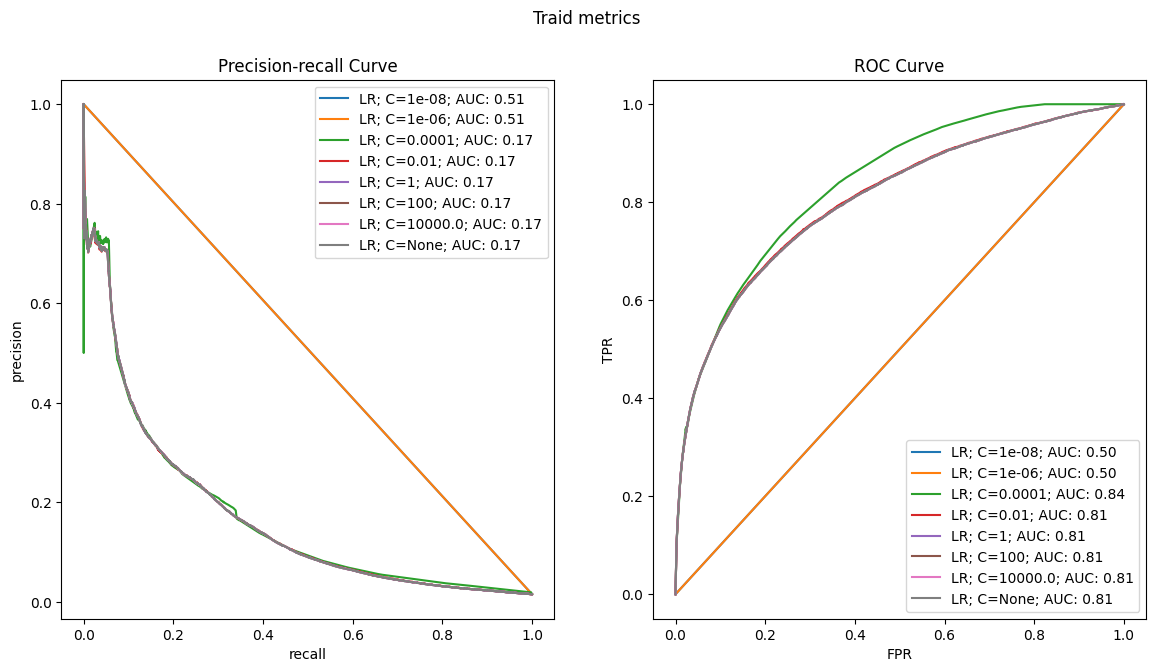

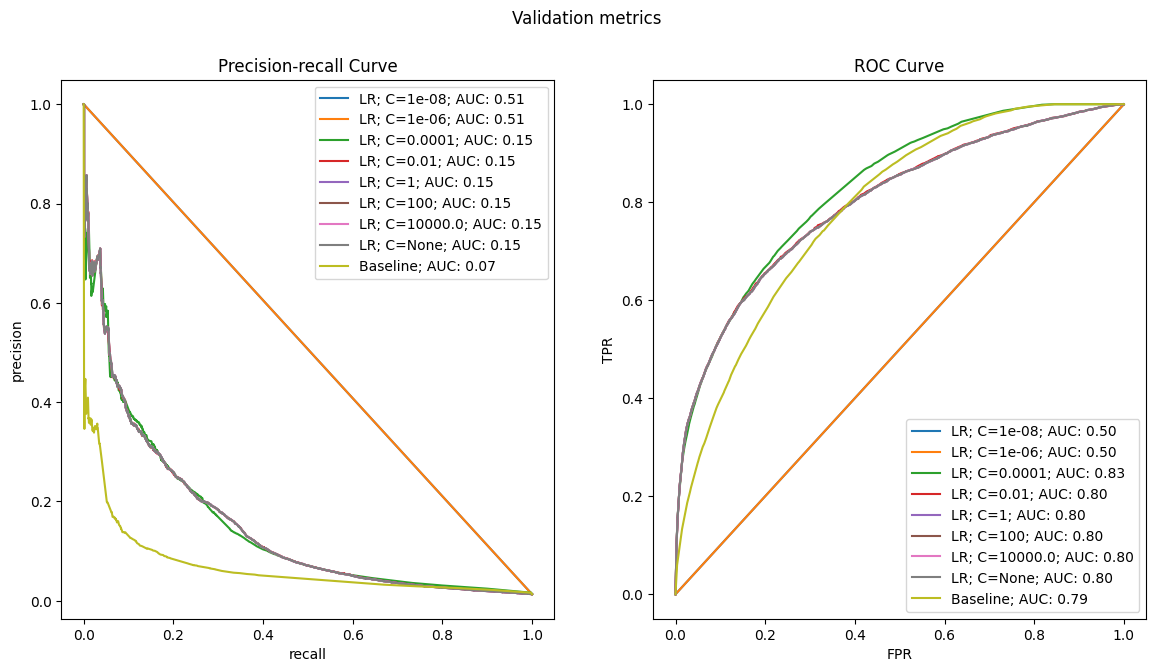

In [54]:
lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []

figl, ax1 = plt.subplots(1, 2, figsize=(14, 7))
figl.suptitle("Traid metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

es = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None]

for c in es:
    lr = make_pipeline(                                        
        StandardScaler(),
        LogisticRegression(penalty="l1" if c else None, C=c if c else 1.0, solver='saga') #solver='saga' es un solver que funciona mejor con regularizacion l1
        #c si es 1e-8 es muy pequeno y hay mucha regularizacion. si es 1e4 es muy grande y hay poca regularizacion. si es None es 1.0
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:, 1]
    plot_metrics(f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(figl, ax1))

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

plot_metrics(f"Baseline", y_pred=val_df['global_popularity'], y_test=val_df[label_col], figure=(fig2, ax2))




1. laso tiene un comporamiento parecido a ridge
2. Como el split no esta bien hecho el train y el test no son iguales, porque hay temporalidad.
3. Demasiada regularizacion hace q tenga un comportamineto raro.

### Coeficient weigths

In [55]:
lr = Pipeline([("standard_scaler", StandardScaler()), ("lr", LogisticRegression(penalty="l2", C=1e-6))])

lr.fit(X_train[train_cols], y_train)

lr_coeff_l2 = pd.DataFrame({"features": train_cols, "importance": np.abs(lr.named_steps ["lr"].coef_[0]),  
                            "regularisation": ["l2"] * len(train_cols)})

lr_coeff_l2 = lr_coeff_l2.sort_values('importance', ascending=True)



lr = Pipeline([("standard_scaler", StandardScaler()), ("lr", LogisticRegression(penalty="l1", C=1e-4, solver="saga"))])
lr.fit(X_train[train_cols], y_train)


lr_coeff_l1 = pd.DataFrame({"features": train_cols, "importance": np.abs(lr.named_steps ["lr"].coef_[0]),
                                "regularisation": "l1"})

lr_coeff_l1 = lr_coeff_l1.sort_values('importance', ascending=True)

<Axes: xlabel='importance', ylabel='features'>

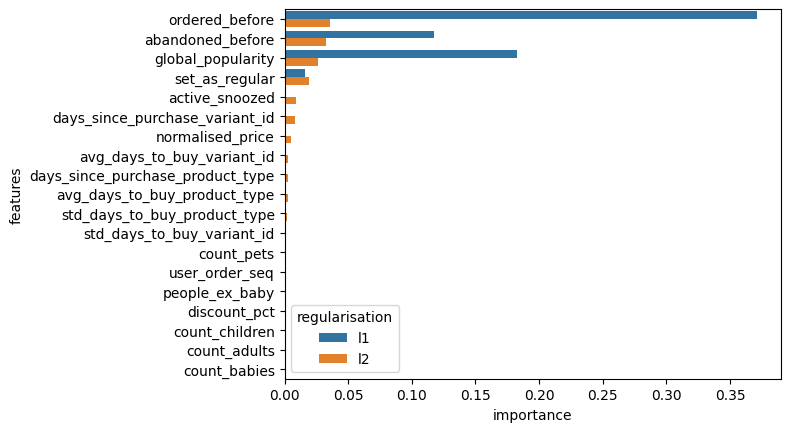

In [56]:
lr_coeff = pd.concat([lr_coeff_l2, lr_coeff_l1])
lr_coeff["features"] = pd.Categorical(lr_coeff["features"])
lr_coeff = lr_coeff.sort_values(by=["importance"])
order_columns = lr_coeff_l2.sort_values(by="importance", ascending=False)["features"]
sns.barplot(data=lr_coeff, x="importance", y="features", hue="regularisation", order=order_columns)

se confirma q l1 tiene a tener mas valores a 0 y da importancia 4 features, y en cambio l2 da valores mas pequeños a mas features por lo de norma 1 y norma 2. Lo q se ha estudiado en teoria se cumple.

se van a quitar las variables no importantes. Para simplificar el modelo y ver si hay diferencias.

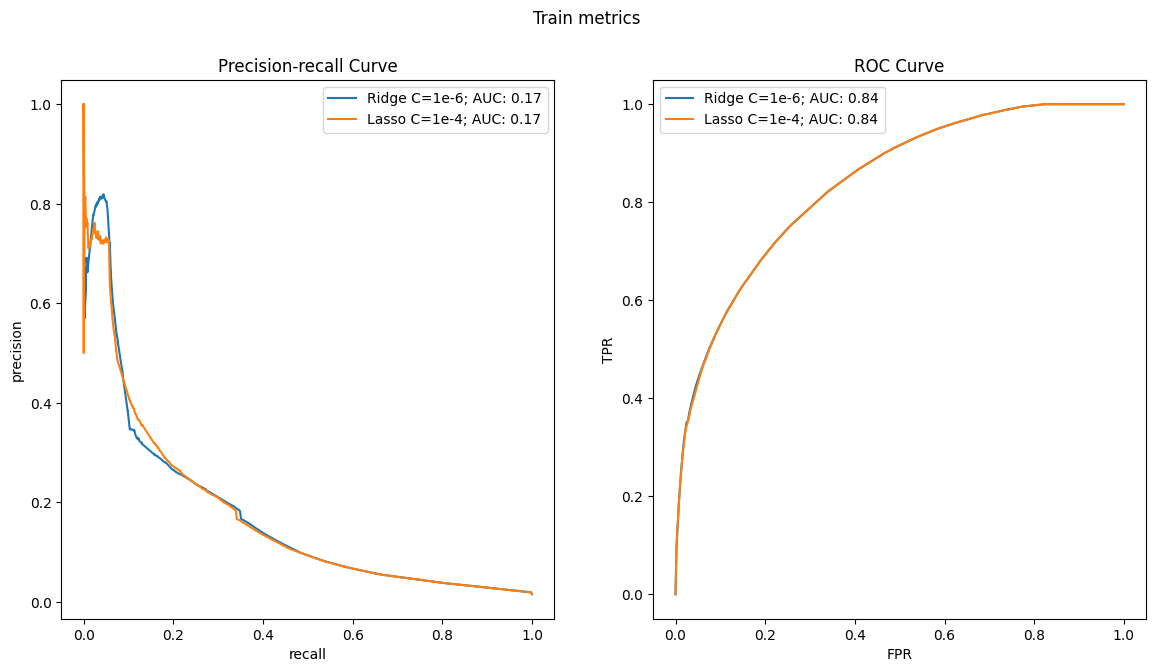

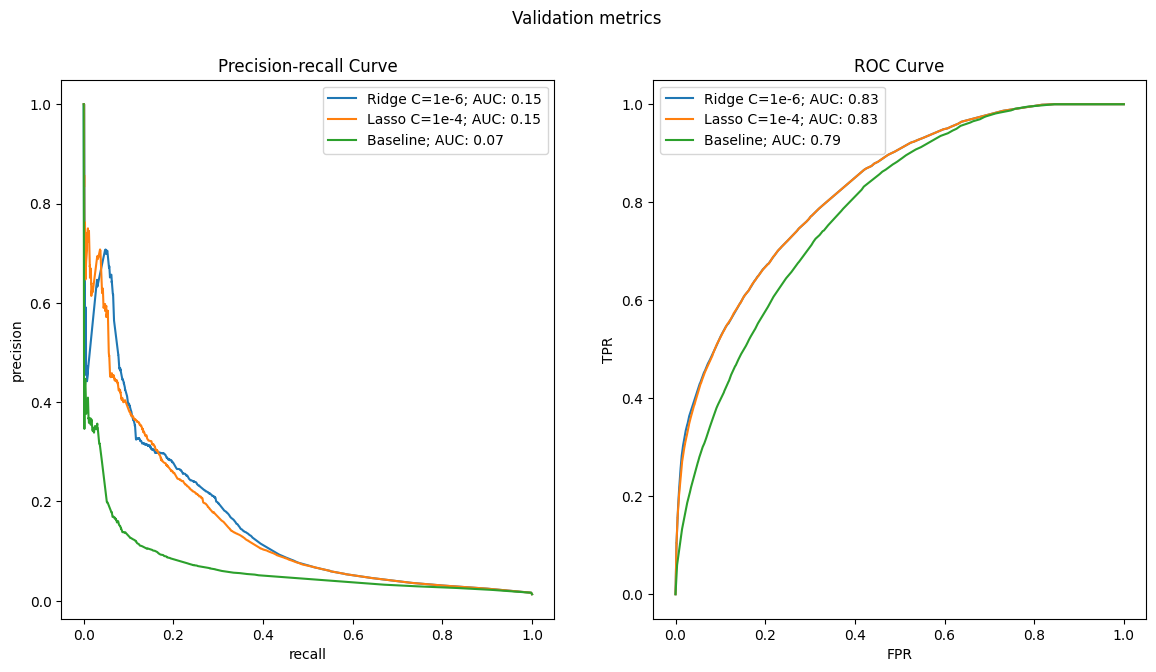

In [57]:
reduced_cols = ['ordered_before', 'abandoned_before', 'global_popularity','set_as_regular']

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(
        StandardScaler(), 
        LogisticRegression(penalty="l2", C=1e-6)
    ),
    make_pipeline(
        StandardScaler(), 
        LogisticRegression(penalty="l1", C=1e-4, solver='saga')
    ),
]

names = ['Ridge C=1e-6', 'Lasso C=1e-4']
for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(name, y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1))

    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(name, y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2))

plot_metrics(f"Baseline", y_pred=val_df['global_popularity'], y_test=val_df[label_col], figure=(fig2, ax2))

1. Usando menos features se consigue curvas parecidad, con esto se consigue q el calculo se vuelva mas sencillo de mantener porque menos cosas pueden fallar y menos cosas hay q actualizar.
2. Sigue siendo mejor q el baseline. Tenemos un modelo simple q mejora el baseline. 